## ARIMA 모델

<br>

* Autoregressive Integrated Moving Average는 개발된지 오래된 방법으로 시계열 데이터 분석을 위해 이해해야 하는 중요한 모델링 또는 예측 기법

<br>

* Stationary VS Non-stationary time series
    * stationary한 데이터가 stationary특성을 가지고 있는 가정하에 ARIMA 모델을 적용

<br>

* Seasonal VS Non-seasonal ARIMA
    * Non-seasonal ARIMA : ARIMA(p,d,q)
    * Seasonal ARIMA : ARIMA(p,d,q)(P,T,Q)m

<br>

* ARIMA <br>
    * Autoregressive - AR(p)
    * Integrated - I(d)
    * Moving Average - MA(q)

<br> 

### 1. Stationary vs Non-Stationary

> Stationary 데이터의 특성
* 연속되는 숫자들의 평균(mean)이 time invariant (시간에 따라 변하지 않는)
* 연속되는 숫자들의 분산(variance)이 time invariant
* 연속되는 숫자들의 공분산(covariance)이 time invariant
* 평균,분산,공분산이 시점에 따라 달라지지 않음
 
> Stationary Test
* ARIMA 모델은 시계열 데이터가 stationary 특성을 보일 때 효과적으로 데이터가 stationary 특성을 보이는지 확인할 수 있어야 함

> Differencing
* 시계열 데이터가 Non-Stationary 하다면 초기 differencing 작업을 ("Intergrated") 한 번 이상 적용하여 데이터를 stationary 하게 만드는 단계가 필요함


<br>

### 2. Stationary Test

> 데이터가 Stationary한지 검증하는 방법

> Augmented Dickey-Fuller test
* 통계적 시험을 통해 시계열 데이터가 stationary 특성을 보이는지 확인할 수 있음
    

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('./data/monthly-milk-production.csv', index_col='Month', parse_dates=True)

In [3]:
df.head()

,pounds per cow
Month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


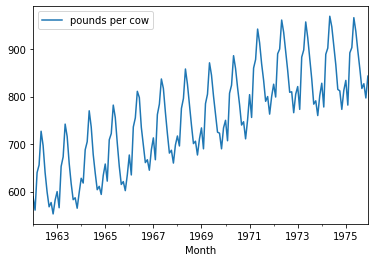

In [4]:
# trend와 계절성 모두를 가지는 데이터
df.plot()

In [5]:
# stationary test
timeseries = df['pounds per cow']

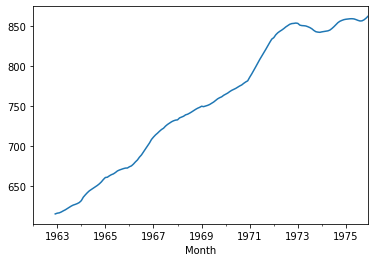

In [6]:
timeseries.rolling(12).mean().plot()

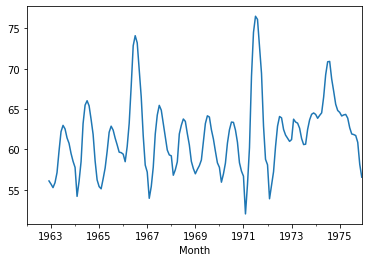

In [7]:
timeseries.rolling(12).std().plot()

> 위 두 그래프를 보았을때, 평균은 뚜렷한 트렌드를 보이고 있으며, 분산은 시점에 따라 값이 달라진다. => Not Stationary

In [8]:
# decomposition 으로 확인하기

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df['pounds per cow'])

<Figure size 432x288 with 0 Axes>

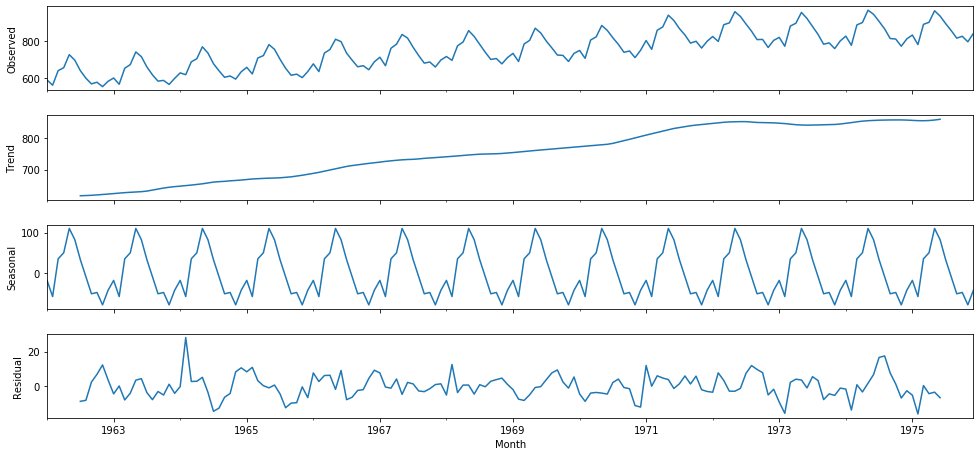

In [9]:
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15,7)

<br>

### 3. Differencing

> Non-Stationary 데이터는 differencing을 통해 stationary하게 변환

> differencing을 한 데이터에 대해 stationary 할 때 까지 differencing을 반복

> 3차 이상 differencing을 하지는 않음

> seasonal 데이터일 경우 season을 기준으로 differencing
* 예를 들어 1년 주기의 seasonality를 갖는 월간 데이터에 대해 differencing 할 때, differencing의 시간 단위는 1이 아니라 12로
* seasonal ARIMA 모델의 경우 1차 differencing 후 seasonal differencing 하는것도 흔히 사용하는 방법 

In [10]:
# stationary test => 함수를 통해 판단하기

from statsmodels.tsa.stattools import adfuller

In [11]:
result = adfuller(df['pounds per cow'])
result ## 2번째값이 p값 => 0.627426.... # p값이 0.5 이내이여야 stationary하다고 판단할 수 있다

(-1.3038115874221294,
 0.6274267086030316,
 13,
 154,
 {'1%': -3.473542528196209,
  '5%': -2.880497674144038,
  '10%': -2.576878053634677},
 1115.1730447395112)

In [12]:
# 함수로 만들기
def adf_check(ts):
    result = adfuller(ts)
    if result[1] <= 0.05:
        print('Stationary {}'.format(result[1]))
    else :
        print('Non-Stationary {}'.format(result[1]))

In [13]:
adf_check(df['pounds per cow'])

Non-Stationary 0.6274267086030316


In [14]:
# first differencing

df['1st diff'] = df['pounds per cow'] - df['pounds per cow'].shift(1)

In [15]:
df.head()

,pounds per cow,1st diff
Month,,
1962-01-01,589,NaN
1962-02-01,561,-28.0
1962-03-01,640,79.0
1962-04-01,656,16.0
1962-05-01,727,71.0


In [16]:
adf_check(df['1st diff'].dropna()) # 1차 differencing결과 stationary 데이터로됨

Stationary 0.030068004001785647


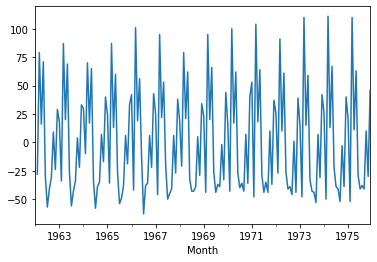

In [17]:
df['1st diff'].plot() # 분산,트렌드 모두 일정

In [18]:
# second differencing

df['2nd diff'] = df['1st diff'] - df['1st diff'].shift(1)

In [19]:
adf_check(df['2nd diff'].dropna()) # 2차 differencing결과 1차 differencing 보다 더 stationary

Stationary 1.1126989332084581e-26


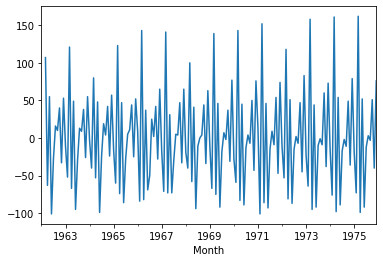

In [20]:
df['2nd diff'].plot()

> 2차 differencing까지 해도 어떤 패턴(seasonality)이 보임. 따라서 seasonal differencing 해주어야 함

In [21]:
## seasonal differencing

df['seasonal diff'] = df['pounds per cow'] - df['pounds per cow'].shift(12)

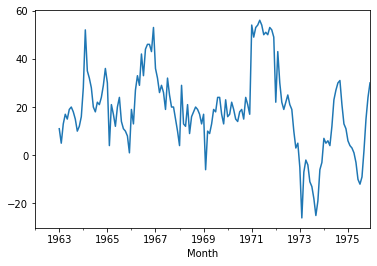

In [22]:
df['seasonal diff'].plot()

In [23]:
adf_check(df['seasonal diff'].dropna()) # seasonal differencing만 해주었을경우 non-stationary

Non-Stationary 0.1607988052771135


In [24]:
# first differencing한 데이터에 seasonal differencing


df['seasonal 1st diff'] = df['1st diff'] - df['1st diff'].shift(12)

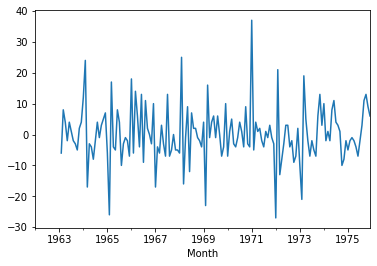

In [25]:
df['seasonal 1st diff'].plot()

In [26]:
adf_check(df['seasonal 1st diff'].dropna())

Stationary 1.8654234318788342e-05


### d,D 인자 결정

* 1st differencing으로 stationary되었으니 d => 1


* 1st differencing에 seasonal differencing하였으니 D => 1

### p,q 인자 결정

In [27]:
### AutoCorrelation

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

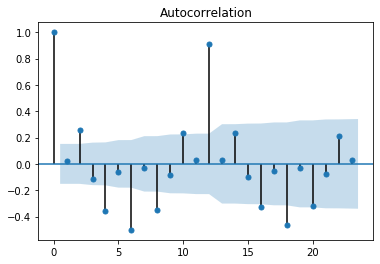

In [28]:
plot_acf(df['1st diff'].dropna()); # 1차 differencing에 대한 AutoCorrelation
# acf = > Q

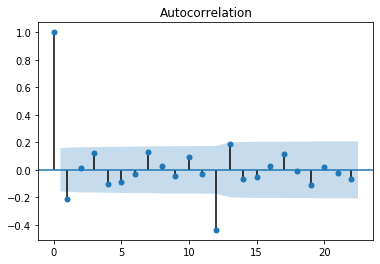

In [29]:
plot_acf(df['seasonal 1st diff'].dropna()); # seasonal 1st differencing에 대한 AutoCorrelation 
# acf => Q 

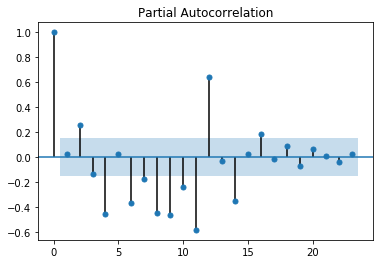

In [30]:
### Partial AutoCorrelation => P

plot_pacf(df['1st diff'].dropna(), method='ywm'); # seasonal 1st differencing에 대한 AutoCorrelation

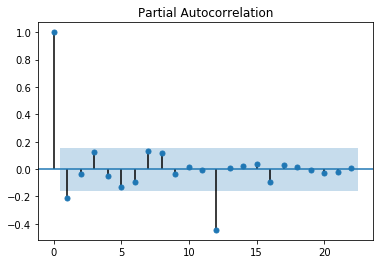

In [31]:
### Partial AutoCorrelation => P

plot_pacf(df['seasonal 1st diff'].dropna(), method='ywm'); # seasonal 1st differencing에 대한 AutoCorrelation

In [32]:
## P=1 Q=1

In [33]:
## p=0,d=0,q=0
## P=1,D=1,Q=1

In [34]:
# 정해진 p,q,d(P,Q,D)로 Seasonal ARIMA모델 fittning

model = sm.tsa.statespace.SARIMAX(df['pounds per cow'],
                                 order=(0,1,0),
                                 seasonal_order=(1,1,1,12))

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [35]:
result = model.fit()

In [36]:
print(result.summary())
# AIC, BIC => 모델의 성능,단순함

                                 Statespace Model Results                                 
Dep. Variable:                     pounds per cow   No. Observations:                  168
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -534.065
Date:                            Mon, 07 Oct 2019   AIC                           1074.131
Time:                                    12:10:19   BIC                           1083.261
Sample:                                01-01-1962   HQIC                          1077.839
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0449      0.106     -0.422      0.673      -0.253       0.163
ma.S.L12      -0.5860      0.102   

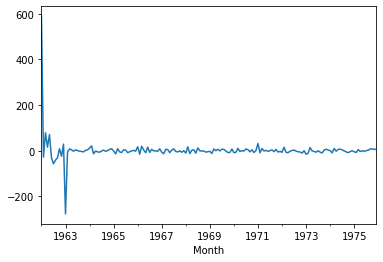

In [37]:
result.resid.plot() # 결과의 residual 보기

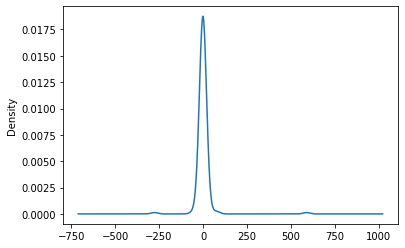

In [38]:
# kde plot으로

result.resid.plot(kind='kde')

In [39]:
df['forecast'] = result.predict(start=150,end=168,dynamic=True) # 150~168번째 데이터를 예측하라

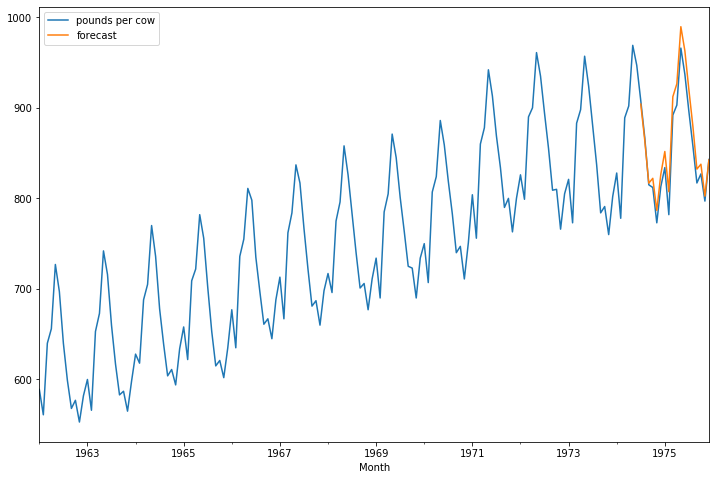

In [40]:
df[['pounds per cow','forecast']].plot(figsize=(12,8))

> ARIMA의 경우 한 스탭씩밖에 예측하나, dynamic=True 인자를 통해 한스탭씩 누적하여 다음스탭을 예측하는 방식 (<b>Rolling Forecatst<b/>)

* p - 자기회귀(Autoregression), 이전 관측치와 현재 관측치와의 관계를 규정 <br>
* d - 시계열모형을 stationary하게 만들기 위해 차분을 이용하는 것 <br>
* q - 이전 관측치의 편차와의 관계를 규정 <br>

## Identification of ARIMA

* p와 q를 결정하는 방법

<br>

* I(d) : stationary로 변환한 order d
* AR(p), MA(q) : AutoCorrelation 플롯과 Partial AutoCorrelation Plot을 참고하여(그려서) p와 q를 결정.

* AutoCorrelation Plot( a.k.a Correlogram)
    * 특정 시간만큼 지연된(lag) 시점의 데이터와 연관성을 보여줌
    
* Partial AutoCorrelation Plot
    * t시점과 특정 시간만큼 지연된(lag) 시점 t-p의 연관성을 그 사이 (t,t-p)데이터의 영향을 배제하고 보여줌 

<br>
    
* Ref :http://people.duke.edu/~rnau/411arim3.htm

#### Autoregresion (AR - p)

* t시점의 데이터와 이전 시점(t-p; lagged p)의 데이터 사이의 관계에 대한 회귀 모델(regression moel)

* 자기 스스로와의 corr 계산 ( 자기 자신의 이전데이터와의)

<br>

#### Moving Average (MA - q)

* movingAverage로 예측한 데이터와 실제데이터와의 residual에 대한 회귀 모델
* t시점의 데이터 이전 시점의 (t-q) moving average의 residual에 대한 회귀 모델
* noise를 예측

## Grid Search를 통한 Parameter Search

* AIC,BIC기준으로

In [41]:
from datetime import datetime

In [42]:
# 현재 month를 datetime으로 인식못함
def dateparser(x):
    return datetime.strptime('190'+x, "%Y-%m") # "1-01" => "1901-01"

In [43]:
shampoo = pd.read_csv('./data/sales-of-shampoo.csv', index_col='Month', parse_dates=True, date_parser=dateparser)

In [44]:
shampoo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36 entries, 1901-01-01 to 1903-12-01
Data columns (total 1 columns):
Sales of shampoo    36 non-null float64
dtypes: float64(1)
memory usage: 576.0 bytes


In [45]:
# stationary test
adf_check(shampoo['Sales of shampoo'])

Non-Stationary 1.0


In [46]:
# 1st diff
shampoo['1st diff'] = shampoo['Sales of shampoo'] - shampoo['Sales of shampoo'].shift(1)

In [47]:
adf_check(shampoo['1st diff'].dropna()) # 1st differencing을 통해 stationary로

Stationary 1.7998574141687034e-10


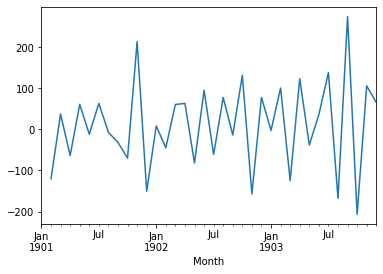

In [48]:
shampoo['1st diff'].plot()

In [49]:
shampoo['2nd diff'] = shampoo['1st diff'] - shampoo['1st diff'].shift(1)

In [50]:
adf_check(shampoo['2nd diff'].dropna())

Stationary 0.0039063349396599245


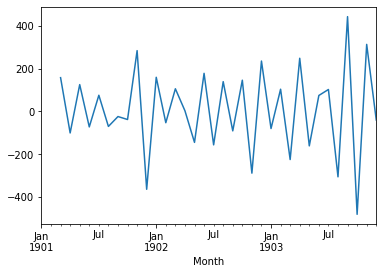

In [51]:
shampoo['2nd diff'].plot()

In [52]:
from statsmodels.tsa.arima_model import ARIMA # SARIMA랑 다른 패키지

In [53]:
# 
p = list(range(0,5))
d = [1,2]
q = [0]

In [54]:
import itertools

In [55]:
pdq = list(itertools.product(p,d,q))

In [56]:
pdq

[(0, 1, 0),
 (0, 2, 0),
 (1, 1, 0),
 (1, 2, 0),
 (2, 1, 0),
 (2, 2, 0),
 (3, 1, 0),
 (3, 2, 0),
 (4, 1, 0),
 (4, 2, 0)]

In [57]:
for param in pdq:
    model = ARIMA(shampoo['Sales of shampoo'], order=param)
    result = model.fit(disp=0)
    print('ARIMA{} => AIC : {}'.format(param,result.aic))

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(

ARIMA(0, 1, 0) => AIC : 430.87311187552797
ARIMA(0, 2, 0) => AIC : 461.1578257086931
ARIMA(1, 1, 0) => AIC : 406.02228959235015
ARIMA(1, 2, 0) => AIC : 423.90008603782104
ARIMA(2, 1, 0) => AIC : 403.62756411659745
ARIMA(2, 2, 0) => AIC : 412.9993824970794
ARIMA(3, 1, 0) => AIC : 404.69245918166916


C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(3, 2, 0) => AIC : 410.9109265846221
ARIMA(4, 1, 0) => AIC : 404.7867685567214


C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(4, 2, 0) => AIC : 403.94822895070763


In [58]:
# p,d,q => (4,2,0)

In [59]:
## 최적 파라미터를 통한 rolling forecast

In [60]:
# train ,test split
X = shampoo['Sales of shampoo'].values
size = int(len(X)*0.66)
train,test = X[:size],X[size:] # train => 앞쪽 23개 

> 즉, 앞쪽 23데이터를 기반으로 그 다음(24번째(test의 첫번째))를 예측함

In [61]:
history = [x for x in train] # train은 그대로 두고 (복사본 생성)

In [63]:
predictions = []

for t in range(len(test)): # test사이즈만큼 prediction
    model = ARIMA(history, order=(4,2,0))
    result = model.fit(disp=0) # disp=0 => warnning메세지 안뜨게
    output = result.forecast() # forcast default인자는 1임 # 즉, 다음거 하나만 예측 # 배열로 저장됨
    yhat = output[0] # yhat => 예측값
    predictions.append(yhat)
    
    # 계속해서 다음꺼 예측하기 위해
    obs = test[t] 
    history.append(obs) # 하나씪 범위 늘림

In [64]:
predictions

[array([405.66897158]),
 array([335.61401502]),
 array([400.47805352]),
 array([376.25048402]),
 array([384.54853011]),
 array([414.62184759]),
 array([490.16113077]),
 array([405.8959166]),
 array([529.89425859]),
 array([601.03128005]),
 array([519.98558896]),
 array([736.66769817]),
 array([562.56886049])]

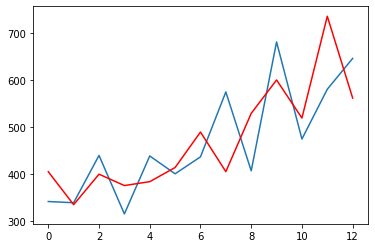

In [70]:
plt.plot(test)
plt.plot(predictions,color='red')

In [67]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test,predictions)

In [68]:
rmse = np.sqrt(error)
rmse

87.15689899409197

In [72]:
shampoo['Sales of shampoo'].describe()

count     36.000000
mean     312.600000
std      148.937164
min      119.300000
25%      192.450000
50%      280.150000
75%      411.100000
max      682.000000
Name: Sales of shampoo, dtype: float64

> std가 148인 RMSE 87인것은 절반넘게 error라는 의미. 좋은모델이 아님 